# CyCIFLung Data Compartment Classification using UTAG


- lung: https://www.cycif.org/data/du-lin-rashid-nat-protoc-2019/
- melanoma: https://www.cycif.org/osd-exhibit#s=4#w=0#g=0#m=-1#a=-100_-100#v=0.4509_0.3861_0.5556#o=-100_-100_1_1#p=Q
- tonsils: https://www.cycif.org/data/du-lin-rashid-nat-protoc-2019/osd-TONSIL_1#s=0#w=0#g=0#m=-1#a=-100_-100#v=0.5_0.5223_0.4008#o=-100_-100_1_1#p=Q
- BRCA: https://www.cycif.org/data/mehta-2020/osd-BRCA-WT-vs-BRCA1-associated-TNBC#s=1#w=6#g=0#m=-1#a=-100_-100#v=0.3331_2.1176_0.5#o=-100_-100_1_1#p=Q

## Loading Libraries and Data

In [2]:
from utag import utag
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["axes.grid"] = False

import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=150, fontsize= 6)

Warning, OS could not be easily identified. Using default dir ~/.utag to store resources but that might not work!


In [3]:
adata = sc.read('data/data/LC_cycif_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 340878 × 26
    obs: 'area', 'perimeter', 'major_axis_length', 'eccentricity', 'solidity', 'X_centroid', 'Y_centroid', 'roi', 'sample', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [4]:
results = sc.read('data/data/LC_cycif_utag_results.h5ad')

# Preprocessing and UTAG

In [ ]:
import seaborn as sns

cm = sns.clustermap(adata.to_df().corr(), cmap = 'coolwarm', vmin = -1, vmax = 1)
var_order = adata.var.iloc[cm.dendrogram_col.reordered_ind].index

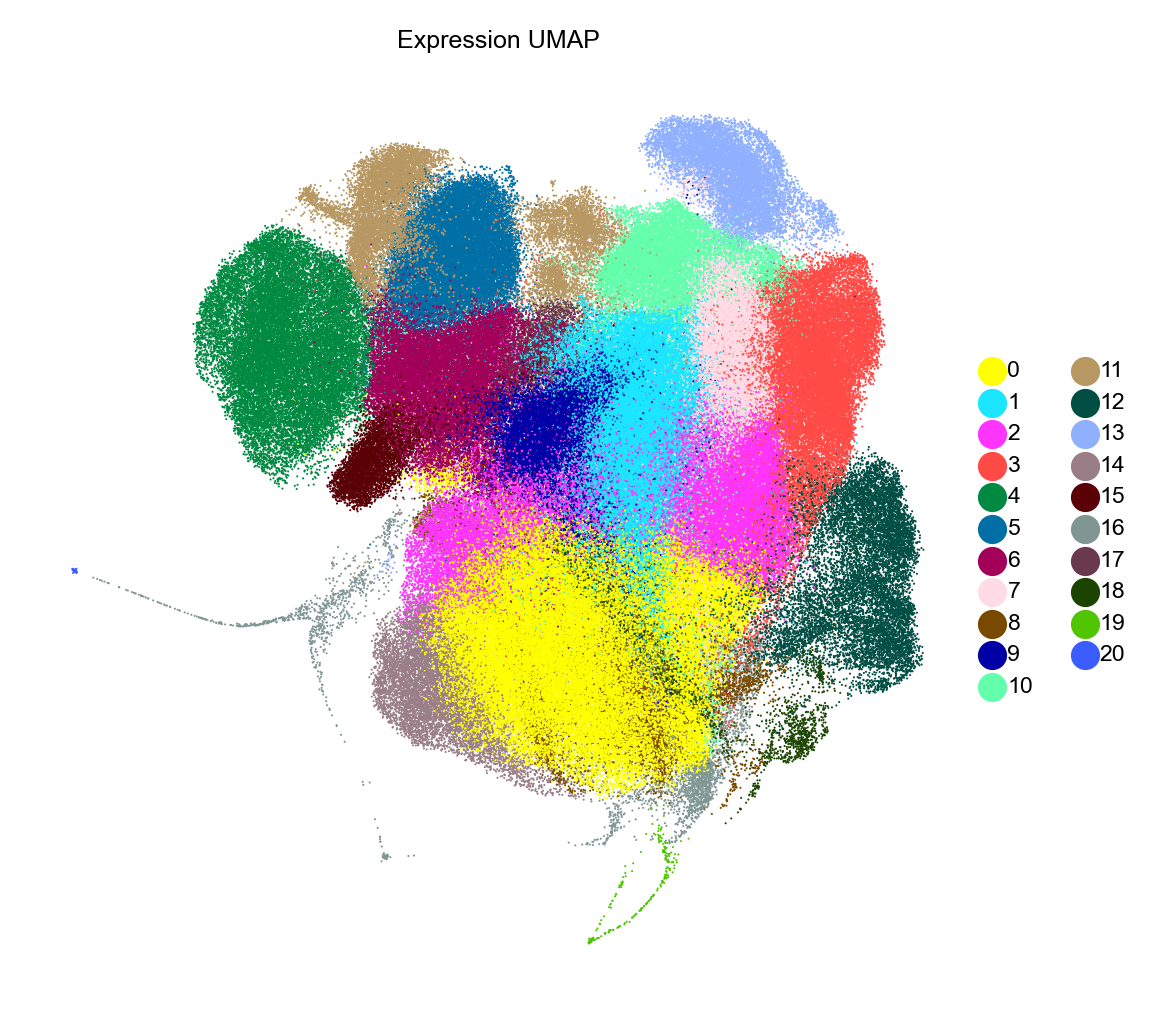

In [5]:
sc.pl.umap(adata, color = 'leiden', title = 'Expression UMAP', frameon = False, size = 1)

In [ ]:
%%time
results = segment_slide(adata, slide_key = 'roi', max_dist = 50, normalize_adjacency_matrix = True, batch_key = 'sample', apply_clustering = True, clustering_method ='parc')

# Labelling UTAG

In [6]:
mapper = {
    '0': 'Stroma', #aSMA+
    '1': 'Tumor', #CD4, CD11b, CD68, CD163
    '2': 'Stroma',
    '3': 'Tumor', #CD3, CD8a, CD45, CD45RB
    '4': 'Stroma',
    '5': 'Low Expression',
    'Empty': 'Stroma',
}

results.obs['UTAG Label'] = pd.Categorical(results.obs['UTAG Label_parc_0.1'])
results.obs['T/S'] = pd.Categorical(results.obs['UTAG Label_parc_0.1'].replace(mapper))

results.uns['T/S_colors'] = ['#EAD2AC', '#33a02c', '#e31a1c']
results.obs['T/S']

LUNG-1-LN-03_cell_48       Stroma
LUNG-1-LN-03_cell_72       Stroma
LUNG-1-LN-03_cell_73       Stroma
LUNG-1-LN-03_cell_79       Stroma
LUNG-1-LN-03_cell_80        Tumor
                            ...  
LUNG-3-PR-02_cell_20330     Tumor
LUNG-3-PR-02_cell_20333     Tumor
LUNG-3-PR-02_cell_20338     Tumor
LUNG-3-PR-02_cell_20343    Stroma
LUNG-3-PR-02_cell_20344     Tumor
Name: T/S, Length: 340878, dtype: category
Categories (3, object): ['Low Expression', 'Stroma', 'Tumor']

In [ ]:
for slide in results.obs['roi'].unique()[:3]:
    result_batch = results[results.obs['roi'] == slide].copy()
    ad_batch = adata[adata.obs['roi'] == slide].copy()
    sample = result_batch.obs['sample'].unique()[0]
    
    fig, ax = plt.subplots(1, 1, figsize = (6,6), dpi = 100)
    sc.pl.spatial(result_batch, color = 'T/S', spot_size = 50, ax = ax, show = False, title = 'UTAG Labels on Image', frameon = False, legend_fontsize = 5, alpha_img = 0)

    #plt.tight_layout()
    plt.show()